# 批量规范化层
### 规范化公式
$$ x_{hat} = \frac{x-mean}{\sqrt{var+\epsilon}} $$
mean是小批量均值，var是小批量方差，$\epsilon$是很小的数（防止除零）
$$ \mathrm{BN}(x) = \boldsymbol{\gamma} \odot x_{hat} + \boldsymbol{\beta} $$
$\boldsymbol{\gamma}$是拉伸参数，$\boldsymbol{\beta}$是偏移参数，加入他们使得归一化的参数仍能恢复不同的表达能力
### 全连接层
在全连接层的仿射变换和激活函数之间应用批量规范化：  
$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$
### 卷积层
在卷积层之后和非线性激活函数之前应用批量规范化  
当我们有 $batch\_size\times height\times width$ 的输入，输出通道为 $num\_channels$ ，   
输出为 $batch\_size\times num\_channels\times height\times width$ .   
我们需要收集每个 $num\_channels$ 的所有 $batch\times height\times width$ 的数据来计算均值和方差，并应用到所有的 $batch\times height\times width$ 上

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enableed来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        X_hat = (X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
            # 如果使用全连接，计算特征维度上的均值和方差
        if len(X.shape) == 2:
            # 对于输入为batch_size*num_features的情况，
            # Xmean(dim=0)是计算每个特征维度(按列)的均值
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else:
            # 如果使用二维卷积，计算通道维度上（axis=1）的均值和方差。
            # 保持X的形状即(batch_size, num_channels, height, width)->
            # (1, num_channels, 1, 1)
            mean = X.mean(dim=(0,2,3), keepdim=True)
            var = ((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat = (X-mean)/torch.sqrt(var+eps)
        # 更新移动平均的均值和方差
        # momentum是动量超参数,一般取0.9或者0.99
        # 为什么使用移动平均而不是mean的平均值(mean在所有batch下的总和/batch数)？
        # 感觉是更方便计算，
        # 如果是后者，我们需要等全部训练完，再收集所有batch*epoch的mean和var，然后计算均值
        # 如果是前者，我们可以实时更新mean和var
        moving_mean = momentum * moving_mean + (1.0-momentum)*mean
        moving_var = momentum * moving_var + (1.0 - momentum)*var
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

In [3]:
class BatchNorm(nn.Module):
    # num_features: 完全连接层的输出数量或卷积层的输出通道数
    # num_dims: 2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为0和1
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        # gamma和beta是可学习参数，需要在模型中迭代优化，
        #  所以需要注册为模型参数参与反向传播和优化
        # moving_mean和moving_var是在训练时被即时计算出来的，不需要优化，

    def forward(self,X):
        # 将moving_mean和moving_var复制到X所在设备上
        # 为什么不需要移动gamma和beta？
        # 模型参数gamma和beta是模型的一部分，会跟随模型自动移动到相应设备
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5,momentum=0.9
        )
        return Y

In [4]:
# 在LeNet模型中添加BatchNorm层
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5), BatchNorm(6,num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*4*4,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNorm(84,num_dims=2),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.266, train acc 0.901, test acc 0.809
24721.2 examples/sec on cuda:0


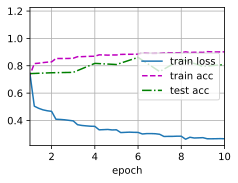

In [5]:
lr, num_epochs, batch_size = 1.0,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.0573, 2.6582, 3.3082, 3.4973, 2.9312, 3.5020], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-0.8661,  2.5405, -1.8091, -1.7687,  3.1855,  1.9776], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [8]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(256,120),nn.BatchNorm1d(120),nn.Sigmoid(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.276, train acc 0.899, test acc 0.877
29159.4 examples/sec on cuda:0


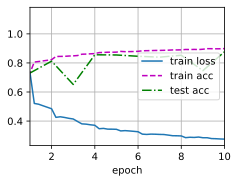

In [9]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())